In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [2]:
# create a connection with the given database
con = sqlite3.connect("../laliga.sqlite")

# read the two tables from the database into Pandas DataFrames
df_matches = pd.read_sql_query("SELECT * from Matches", con)
df_predictions = pd.read_sql_query("SELECT * from Predictions", con)

# close the connection of the database
con.close()

# Exercise 1
Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.

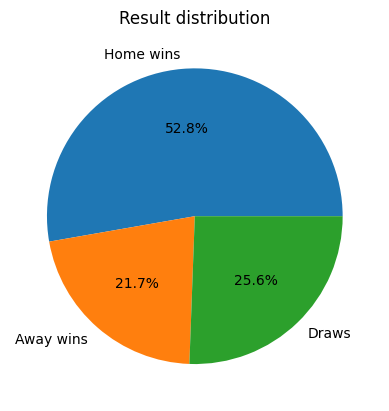

In [3]:
# creating two new columns, one for the score of the home team, and one for the score of the away team
df_matches[['home_score', 'away_score']] = df_matches['score'].str.split(':', expand=True).astype(float)

# creating one new column to show which team won (1 for home team, 2 for away team), or if it was a tie (X)
df_matches['winner'] = df_matches.apply(lambda row: 
                                        np.nan if pd.isna(row['home_score']) or pd.isna(row['away_score'])
                                        else 1 if row['home_score'] > row['away_score']
                                        else 2 if row['home_score'] < row['away_score']
                                        else 'X', axis=1)

# getting the counts for the values 1, 2 and X in the winner column
result_counts = df_matches['winner'].value_counts()

# extracting the counts for each specific value, making it 0 if it does not exist
number_home_wins = result_counts.get(1, 0)
number_away_wins = result_counts.get(2, 0)
number_draws = result_counts.get('X', 0)

# getting the total number of games played by summing the counts for all the possible game results
total_plays = number_home_wins + number_away_wins + number_draws

# defining the value array for the pie plot
y = np.array([number_home_wins, number_away_wins, number_draws])
# defining the lables for the pie plot
labels = ['Home wins', 'Away wins', 'Draws']

# initiating and plotting the pie plot including the percentages of the three options
plt.pie(y, labels = labels, autopct = "%1.1f%%")
plt.title('Result distribution')
plt.show()

# Exercise 2
What are the top ten scoring teams of all time? What are the ten teams that concede the most? Make two bar plot charts showing each of them. Consider only matches played in 1st division. What have been the biggest wins? Of course, when we say biggest we mean those with the highest goal difference. Show the top ten of them in a table.

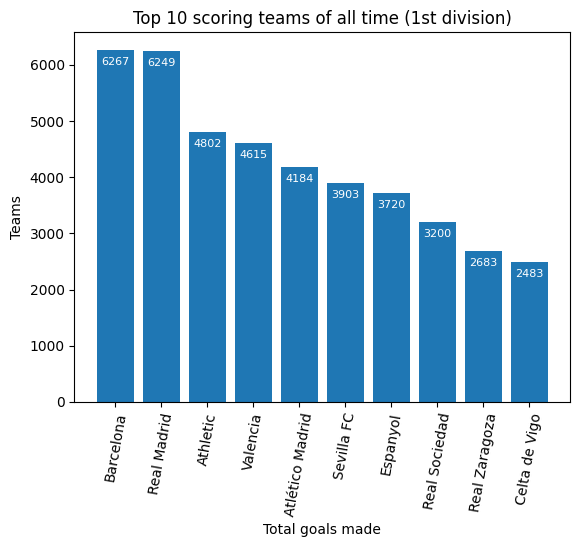

In [4]:
# create two subsets of the df_matches dataframe filtering on division 1 and aggregating the total made goals for the teams when playing at home and when playing away
df_home_goals = df_matches[df_matches['division'] == 1].groupby('home_team')['home_score'].sum()
df_away_goals = df_matches[df_matches['division'] == 1].groupby('away_team')['away_score'].sum()

# combine the subsets into a new dataframe, also creating a total column with the total amount of goals a club has made
df_rank = pd.DataFrame({'home_goals': df_home_goals, 'away_goals': df_away_goals, 'total_goals': df_home_goals + df_away_goals})

# get the top 10 clubs that made the most goals
top_10_goals = df_rank[['total_goals']].sort_values('total_goals', ascending=False).head(10)

# plot the top 10 teams and the amount of goals they scored
plt.bar(top_10_goals.index, top_10_goals['total_goals'])
plt.xlabel('Total goals made')
plt.ylabel('Teams')
plt.title('Top 10 scoring teams of all time (1st division)')
plt.xticks(top_10_goals.index, top_10_goals.index, rotation=80)
for i, value in enumerate(top_10_goals['total_goals']):
    plt.text(i, value-300, str(int(value)), ha='center', va='bottom', fontsize=8, color='white')
plt.show()

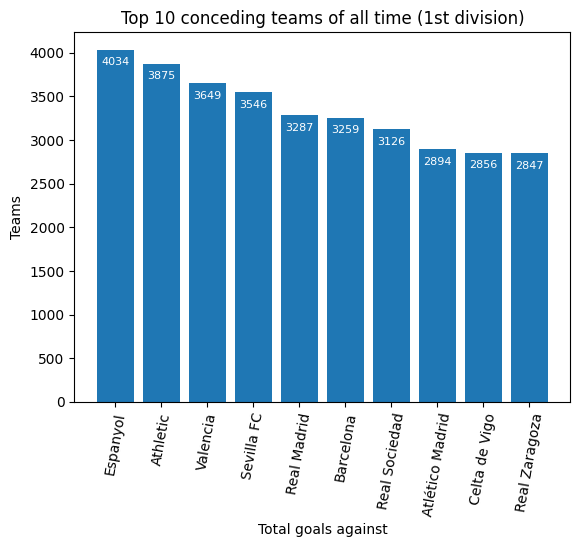

In [5]:
# create two subsets of the df_matches dataframe filtering on division 1 and aggregating the total made goals against every team when playing at home and when playing away
df_home_concedes = df_matches[df_matches['division'] == 1].groupby('home_team')['away_score'].sum()
df_away_concedes = df_matches[df_matches['division'] == 1].groupby('away_team')['home_score'].sum()

# combine the subsets into a new dataframe, also creating a total column with the total amount of goals a club has had against them
df_concede = pd.DataFrame({
    'home_concedes': df_home_concedes,
    'away_concedes': df_away_concedes,
    'total_concedes': df_home_concedes + df_away_concedes
})

# get the top 10 clubs that had the most goals against them
top_10_concede = df_concede[['total_concedes']].sort_values('total_concedes', ascending=False).head(10)

# plot the top 10 teams and the amount of goals they got against them
plt.bar(top_10_concede.index, top_10_concede['total_concedes'])
plt.xlabel('Total goals against')
plt.ylabel('Teams')
plt.title('Top 10 conceding teams of all time (1st division)')
plt.xticks(top_10_concede.index, top_10_concede.index, rotation=80)
for i, value in enumerate(top_10_concede['total_concedes']):
    plt.text(i, value-200, str(int(value)), ha='center', va='bottom', fontsize=8, color='white')
plt.show()

In [6]:
# creating a new column for the absolute difference between the score of the team playing at home and the visiting team
df_matches['difference'] = abs(df_matches['home_score'] - df_matches['away_score'])
biggest_wins = df_matches[['date', 'home_team', 'away_team', 'score', 'difference']].sort_values(['difference'], ascending = [False]).reset_index(drop=True)

# showing the table with the top 10 biggest wins
print("Top 10 - Biggest wins\n")
biggest_wins.head(10)

Top 10 - Biggest wins



,date,home_team,away_team,score,difference
0,1/8/41,Real Sociedad,Real Valladolid,14:2,12.0
1,2/8/31,Athletic,Barcelona,12:1,11.0
2,1/13/57,Real Gijón,Lérida,11:0,11.0
3,9/29/40,Sevilla FC,Barcelona,11:1,10.0
4,9/4/49,CE Sabadell,SD Erandio Club,11:1,10.0
5,9/28/41,Sevilla FC,Real Oviedo,10:0,10.0
6,11/11/62,Real Sociedad,CE Sabadell,11:1,10.0
7,1/11/42,Athletic,Celta de Vigo,10:0,10.0
8,11/19/50,Athletic,Lérida,10:0,10.0
9,10/20/57,Atlético Madrid,UD Las Palmas,9:0,9.0


# Exercise 3
There has been a lot of discussion about how LaLiga’s television rights have changed game schedules in the last years. Make a bar plot chart showing the number of matches played each weekday, and make also a histogram of match time. Compare this two graphics between seasons 2000-2001 and 2020-2021.

In [7]:
# function change the 2 digit representation of the year in the "date" column to a 4 digit representation
def get_year(season, date):
    # get only the 2 digit year part of the date
    year = date.split("/")[-1]
    
    # split the years of the season into two separate years
    season_years = season.split("-")
    
    # check if the 2 digit year part of the date are equal to the last part of the start year or the end year of the season
    for season_year in season_years:
        # if the 2 digit part is equal to the last part of one of the season years
        if year == season_year[2:4]:
            # return the complete date, now containing a 4 digit year representation
            return f"{date.split('/')[0]}/{date.split('/')[1]}/{season_year}"

In [8]:
# improve the "date" column using the "get_year" function to change the year from 2 digits to the correct 4 digits
df_matches['date'] = df_matches.apply(lambda row: get_year(row['season'], row['date']), axis=1)

# change the "date" column to datetime
df_matches['date'] = pd.to_datetime(df_matches['date'], format='mixed')

# add a weekday column to store which day of the week the match was played
df_matches['dayWeek'] = df_matches['date'].dt.dayofweek
df_matches['weekday'] = df_matches['date'].dt.day_name()

# change the "time" column to datetime
df_matches['time'] = pd.to_datetime(df_matches['time'], format='%I:%M %p', errors='coerce').dt.time

# add an extra column with the time in hours from midnight (so 12:15 AM is 0.25 hours and 1 PM is 13.0 hours)
df_matches['time_in_hours'] = df_matches['time'].apply(lambda x: x.hour + x.minute / 60 if pd.notna(x) else None)

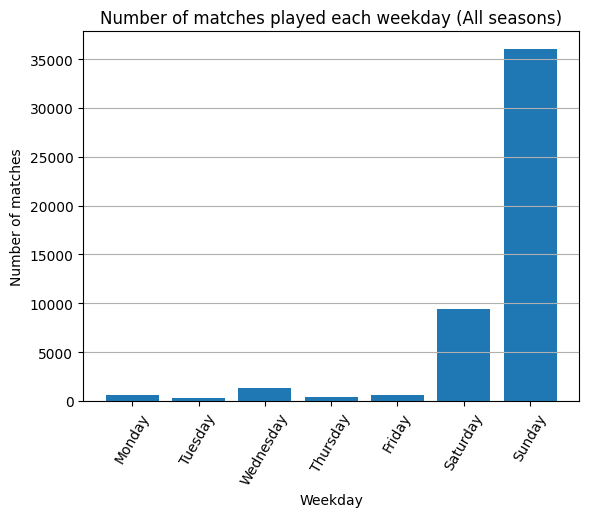

In [9]:
# create a crosstab to find the amount of matches for every season on every day
weekday_counts = pd.crosstab(df_matches['weekday'], df_matches['season'])

# reindex the crosstab so the days are in the right order and empty cells are filled with 0
weekday_counts = weekday_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

# add a total column for the total amount of matches for each day for all the seasons combined
weekday_counts['total'] = weekday_counts.sum(axis=1)

# plot the weekday names and their counts
plt.bar(weekday_counts.index, weekday_counts['total'])
plt.xlabel('Weekday')
plt.ylabel('Number of matches')
plt.title('Number of matches played each weekday (All seasons)')
plt.xticks(weekday_counts.index, weekday_counts.index, rotation=60)
plt.grid(axis='y')
plt.show()


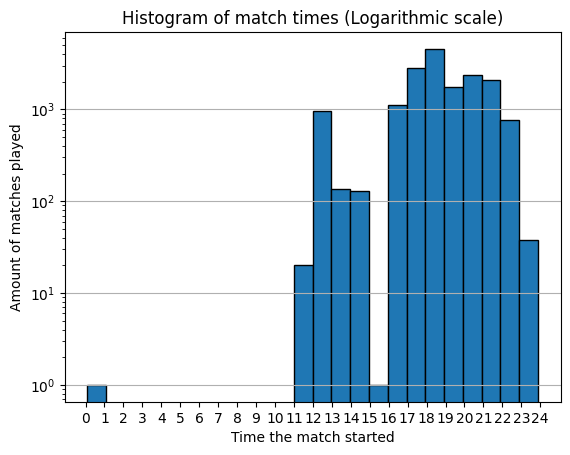

In [10]:
# plot the match times in a logarithmic scale to make sure that all the times (also the ones that are barely in the database) are visable
plt.hist(df_matches['time_in_hours'].dropna(), bins=24, edgecolor='black', log=True)
# set the xticks from 0 to 25 to represent the 24 hours in a day
plt.xticks(range(0, 25))

# Add labels and title
plt.xlabel('Time the match started')
plt.ylabel('Amount of matches played')
plt.title('Histogram of match times (Logarithmic scale)')
# turn on the grid
plt.grid(axis='y')
plt.show()

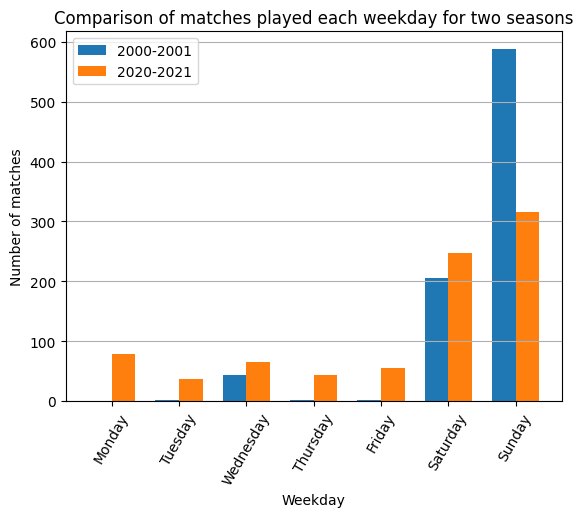

In [11]:
# use the same "weekday_counts" crosstab as before and get the counts for the seasons 2000-2001 and 2020-2021
counts_2000_2001 = weekday_counts['2000-2001']
counts_2020_2021 = weekday_counts['2020-2021']

# define the bar width and set the positions of the bars
bar_width = 0.35
index = np.arange(len(weekday_counts.index))

# create two bars, one for each season
plt.bar(index, counts_2000_2001, bar_width, label='2000-2001')
plt.bar(index + bar_width, counts_2020_2021, bar_width, label='2020-2021')

# plot the weekdays and their counts for the two seasons
plt.xlabel('Weekday')
plt.ylabel('Number of matches')
plt.title('Comparison of matches played each weekday for two seasons')
plt.xticks(index + bar_width / 2, weekday_counts.index, rotation=60)
plt.grid(axis='y')
plt.legend()
plt.show()

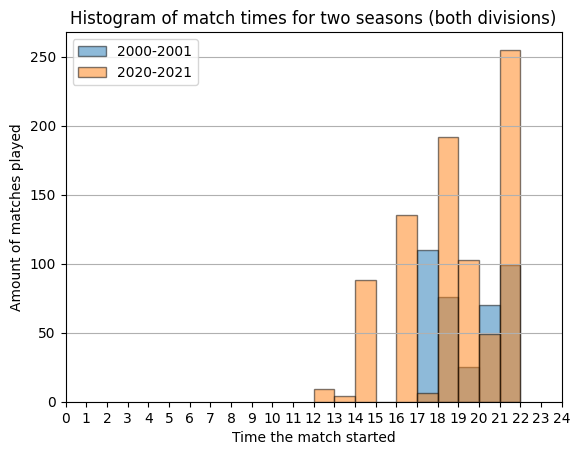

In [12]:
# create two histograms, one for each of the two seasons, NOT filtered on division 
plt.hist(df_matches[df_matches['season'] == '2000-2001']['time_in_hours'], bins=5, alpha=0.5, edgecolor='black', label='2000-2001')
plt.hist(df_matches[df_matches['season'] == '2020-2021']['time_in_hours'], bins=10, alpha=0.5, edgecolor='black', label='2020-2021')

# set the xticks from 0 to 25 to represent the 24 hours in a day
plt.xticks(range(0, 25))

# Add labels and title
plt.xlabel('Time the match started')
plt.ylabel('Amount of matches played')
plt.title('Histogram of match times for two seasons (both divisions)')
plt.legend()
plt.grid(axis='y')
plt.show()

In [13]:
df_matches[(df_matches['time'].isna())&(df_matches['season'].isin(['2000-2001','2020-2021']))][['season','division']].value_counts()

season     division
2000-2001  2           462
2020-2021  2             1
Name: count, dtype: int64

Due to the lack of information about the times, specially for the second division of the 2000-2001 season, below it is shown the comparison of the times of the first division matches

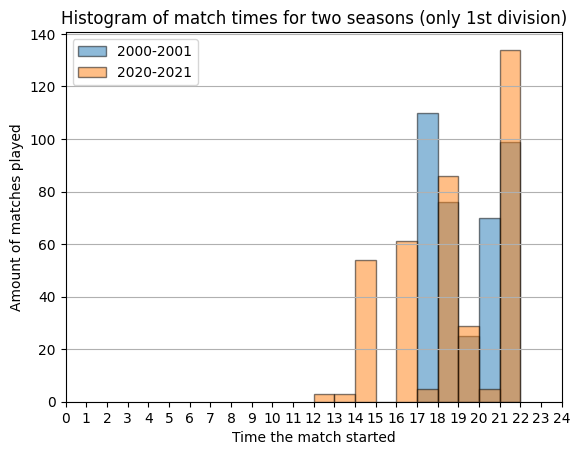

In [14]:
# create two histograms, one for each of the two seasons, filtered on division 
plt.hist(df_matches[(df_matches['season'] == '2000-2001') & (df_matches['division'] == 1)]['time_in_hours'], bins=5, alpha=0.5, edgecolor='black', label='2000-2001')
plt.hist(df_matches[(df_matches['season'] == '2020-2021') & (df_matches['division'] == 1)]['time_in_hours'], bins=10, alpha=0.5, edgecolor='black', label='2020-2021')

# set the xticks from 0 to 25 to represent the 24 hours in a day
plt.xticks(range(0, 25))

# Add labels and title
plt.xlabel('Time the match started')
plt.ylabel('Amount of matches played')
plt.title('Histogram of match times for two seasons (only 1st division)')
plt.legend()
plt.grid(axis='y')
plt.show()

# Exercise 4
Build a cross results table for season 2020-2021 (1st division). Figure 1 is an example taken from Wikipedia. Try to make it the most similar to this one: use team abbreviations as column names and paint the background of each cell according to result (green in case local team wins and red in case visitor team wins). Also, could you model the intensity of this background color with the goal difference from the match?<br>
<img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEjkVXElpmGh5eVaSjKFkNpWmiUBTbvXyF4_DN9IXFFeRvn1RRiOIG014-YhPOw6VrNzRjfzehrWpL2iJjpLKpVc5oXxlKh6NzsZkSQIaA-KdVk65MUWsMpEFiDENS99evghA9wGoUNL1CVYko6W1ufyZkIHM7NGw9HISaOSWkUxuG3Ut2UOyCXnZEU622M/s907/1995%201996%20Liga%20Este27b.jpg" alt="Figure 1. Cross results table" width="600">
<br>
Write a function that, given the season and division, plots the cross results table. Function prototype should be like plot_cross_results_table(season, division) and return the plot object.

In [15]:
# mapping for all the clubs in the database to their shortened version
conversion = {
    'AD Almería': 'ADA',
    'Alavés': 'ALA',
    'Albacete': 'ALB',
    'Alcorcón': 'ALC',
    'Algeciras CF': 'ALG',
    'Alicante CF': 'ALI',
    'Alzira': 'ALZ',
    'Arenas Club': 'ARE',
    'Arosa SC': 'ARO',
    'At. Madrileño': 'MAD',
    'Ath. Aviación': 'AVI',
    'Athletic': 'ATH',
    'Athletic Madrid': 'AMA',
    'Atl. Aviación': 'AVN',
    'Atl. Baleares ': 'BAL',
    'Atl. Madrid B': 'ATB', 
    'Atl. Marbella': 'AMB',
    'Atlético Ceuta': 'ACE',
    'Atlético Madrid': 'ATL',
    'Atlético Tetuán': 'TET',
    'Avilés Ind.': 'AVL', 
    'Badajoz 1905': 'BAD',
    'Baracaldo': 'BRC',  
    'Barcelona': 'BAR',
    'Barcelona Atl.': 'BAA',
    'Barcelona B': 'BAB',
    'Bilbao Athletic': 'BIL',
    'Burgos CF': 'BUR',
    'CA Osasuna': 'OSA',
    'CD Alcoyano': 'ALY',
    'CD Basconia': 'BAS',
    'CD Castellón': 'CAS',
    'CD Condal': 'CON',
    'CD Guadalajara': 'GUA',
    'CD Leganés': 'LEG',
    'CD Logroñés': 'LOG',
    'CD Lugo': 'LUG',
    'CD Mirandés': 'MIR',
    'CD Málaga': 'CMA', 
    'CD Numancia': 'NUM',
    'CD Ourense': 'OUR',
    'CD Tenerife': 'TEN',
    'CD Toledo': 'TOL',
    'CE Constància': 'CTN',
    'CE Europa': 'EUR',
    'CE L’Hospitalet': 'HOS',
    'CE Sabadell ': 'SAB',
    'CF Badalona': 'BDL', 
    'CF Extremadura': 'EXT',
    'CF Fuenlabrada': 'FUE',
    'CF Palencia': 'PAL',
    'CFJ Mollerussa': 'MOL',
    'CP Mérida': 'MER',
    'Calvo Sotelo': 'CAL',
    'Cartagena FC': 'CTG',
    'Castilla CF': 'CST', 
    'Catalunya': 'CAT',
    'Caudal': 'CAU',
    'Celta de Vigo': 'CEL',
    'Ciudad Murcia': 'CIM',
    'CyD Leonesa': 'LEO',
    'Cádiz CF': 'CAD',
    'Córdoba': 'COR',
    'Córdoba CF': 'CCF',
    'Dep. Aragón': 'ARA',
    'Dep. La Coruña': 'DEP',
    'Donostia': 'DON',
    'Elche CF': 'ELC',
    'Espanyol': 'ESP',
    'Extremadura': 'EXR', 
    'FC Cartagena': 'FCC',
    'Ferrol': 'FER',
    'Getafe': 'GET',
    'Gimnàstic': 'GIM',
    'Gimnástica': 'GMS', 
    'Girona': 'GIR',
    'Granada 74 CF': 'G74',
    'Granada CF': 'GRA',
    'Hércules CF': 'HER',
    'Indauchu': 'IND',
    'La Felguera': 'FEL',
    'Levante': 'LEV',
    'Linares CF': 'LIN',
    'Llagostera': 'LAG',
    'Lorca Dep.': 'LOR',
    'Lorca FC': 'LFC',
    'Lérida': 'LER',
    'Mestalla': 'MES',
    'Moscardó': 'MOS',
    'Málaga B': 'MAB',
    'Málaga CF': 'MAL',
    'Onteniente ': 'ONT',
    'Orensana': 'ORE',
    'Orense': 'ORN', 
    'Orihuela Dep.': 'ORI',
    'Palamós CF': 'PMS',
    'Poli Ejido': 'PEJ',
    'Ponferradina': 'PNF',
    'Pontevedra': 'PNT',
    'R. Majadahonda': 'MAJ',
    'RCD Mallorca': 'RCD',
    'RCD Mallorca B ': 'RCB',
    'RM Castilla': 'RMC',
    'Racing': 'RAC',
    'Racing Ferrol': 'RFC', 
    'Rayo Vallecano': 'RAY',
    'Real Betis': 'BET',
    'Real Burgos CF': 'RBC', 
    'Real Gijón': 'GIJ',
    'Real Jaén CF': 'JAE',
    'Real Madrid': 'RMA',
    'Real Madrid B': 'RMB',
    'Real Murcia': 'MUR',
    'Real Oviedo': 'OVI',
    'Real Sociedad': 'RSO',
    'Real Sociedad B': 'RSB',
    'Real Unión': 'RUN',
    'Real Valladolid': 'RVA',
    'Real Zaragoza': 'ZAR',
    'Recr. Huelva': 'HLV',
    'Reus Deportiu': 'REU',
    'SD Amorebieta': 'AMO',
    'SD Ceuta': 'SDC',
    'SD Compostela': 'COM',
    'SD Eibar': 'EIB',
    'SD Erandio Club': 'ERC',
    'SD Huesca': 'HUE',
    'SG Lucense': 'LUC',
    'San Andrés': 'SAN',
    'Sestao River ': 'SRI',
    'Sestao Sport': 'SES',
    'Sevilla Atl.': 'SEA',
    'Sevilla FC': 'SEV',
    'Sporting Gijón': 'GJI',
    'Tarrasa': 'TAR',
    'Terrassa FC': 'TER',
    'UCAM Murcia': 'UCM',
    'UD Almería': 'ALM',
    'UD Ibiza': 'IBZ',
    'UD Las Palmas': 'LPA',
    'UD Logroñés': 'UDL', 
    'UD Salamanca': 'SAL',
    'UD Vecindario': 'VEC',
    'UE Figueres': 'FIG',
    'UE Lleida': 'LLE',
    'UP Langreo': 'LAN',
    'Uni. Las Palmas': 'ULP',
    'Valencia': 'VAL',
    'Villarreal': 'VIL',
    'Villarreal CF B': 'VIB',
    'Xerez CD': 'XER',
    'Écija Balompié': 'EBA',
}

# the reverse mapping
reverse_conversion = {v: k for k, v in conversion.items()}

In [16]:
# function to plot the cross table for a given season and division|
def plot_cross_results_table(season, division):
    # create a copy of df_matches filtering on the given season and division, only keep the usefull columns
    df_cross_table = df_matches[(df_matches['season'] == season) & (df_matches['division'] == division)][['home_team', 'away_team', 'score', 'winner', 'difference']].copy()

    # map away_team to the mapping in the conversion name dict
    df_cross_table['away_team'] = df_cross_table['away_team'].map(conversion)

    # sort the away_team (the columns of the pivot table) and home_team (the index of the pivot table) alphabetically based on the short team names
    sorted_columns = sorted(df_cross_table['away_team'].unique())
    sorted_index = [reverse_conversion[short_name] for short_name in sorted_columns]

    # create a pivot table, reindexed on the sorted columns and index
    pivot_table = df_cross_table.pivot_table(index='home_team', columns='away_team', values='score', aggfunc='first').reindex(columns=sorted_columns, index=sorted_index)
    # also create a pivot table for the difference and winner values, indexing the same way as the pivot table
    difference_pivot = df_cross_table.pivot_table(index='home_team', columns='away_team', values='difference', aggfunc='first').reindex(columns=sorted_columns, index=sorted_index)
    winner_pivot = df_cross_table.pivot_table(index='home_team', columns='away_team', values='winner', aggfunc='first').reindex(columns=sorted_columns, index=sorted_index)

    # replace NaN with '-' (fill the diagonal)
    pivot_table = pivot_table.fillna('-')
    
    # if the away team won, reverse the difference
    adjusted_diff = difference_pivot.where(winner_pivot != 2, -difference_pivot)
    
    # get the absolute maximum value of the difference
    max_diff = max(abs(np.nan_to_num(adjusted_diff.values.flatten())))
    
    # normalize the difference so that it will be between 0 and 1
    normalized_diff = adjusted_diff.fillna(0)
    normalized_diff = (normalized_diff - (-max_diff)) / (max_diff - (-max_diff))
    
    # apply a colormap to the normalized difference
    color_map = plt.cm.RdYlGn(normalized_diff)
    color_rgba = np.apply_along_axis(lambda color: f'background-color: rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 1)', 2, color_map)
    
    # create a new dataframe with the same indexing as the pivot table (making it the same size)
    color_df = pd.DataFrame(color_rgba, index=normalized_diff.index, columns=normalized_diff.columns)
    
    # apply the colors to the origional pivot table, and make the NaN values (diagonal) white
    styled_pivot_table = pivot_table.style.apply(lambda _: color_df, axis=None)
    color_df = color_df.where(~difference_pivot.isna(), 'background-color: white')
    return styled_pivot_table

In [17]:
plot_cross_results_table('2020-2021', 1)

away_team,ALA,ATH,ATL,BAR,BET,CAD,CEL,EIB,ELC,GET,GRA,HUE,LEV,OSA,RMA,RSO,RVA,SEV,VAL,VIL
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:1,1:3,2:1,0:2,0:0,4:2,1:0,2:2,0:1,1:4,0:0,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,4:0,0:1,0:2,1:1,1:0,5:1,2:1,2:0,2:0,2:2,0:1,0:1,2:2,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:0,4:0,2:2,5:0,3:1,1:0,6:1,2:0,0:2,2:1,1:1,2:1,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,5:2,1:1,1:2,1:1,3:0,5:2,1:2,4:1,1:0,4:0,1:3,2:1,1:0,1:1,2:2,4:0
Real Betis,3:2,0:0,1:1,2:3,-,1:0,2:1,0:2,3:1,1:0,2:1,1:0,2:0,1:0,2:3,0:3,2:0,1:1,2:2,1:1
Cádiz CF,3:1,0:4,2:4,2:1,0:1,-,0:0,1:0,1:3,0:2,1:1,2:1,2:2,0:2,0:3,0:1,0:0,1:3,2:1,0:0
Celta de Vigo,2:0,0:0,0:2,0:3,2:3,4:0,-,1:1,3:1,1:0,3:1,2:1,2:0,2:1,1:3,1:4,1:1,3:4,2:1,0:4
SD Eibar,3:0,1:2,1:2,0:1,1:1,0:2,0:0,-,0:1,0:0,2:0,1:1,0:1,0:0,1:3,0:1,1:1,0:2,0:0,1:3
Elche CF,0:2,2:0,0:1,0:2,1:1,1:1,1:1,1:0,-,1:3,0:1,0:0,1:0,2:2,1:1,0:3,1:1,2:1,2:1,2:2


# Exercise 5
As you surely know, there has always been a historical rivalry between Barcelona and Real Madrid. But which of them has won the most games in direct confrontations? Which of them has scored the most goals in these games? Show both things in two pie charts, side by side. Remember to consider ties in the first one.<br>
Write a function that, given two team names, plots the two graphs described above. Function prototype should be like _plot_direct_confrontations_stats(team1, team2)_ and return the plot object. Use it with some other classical rivals like Betis and Sevilla.

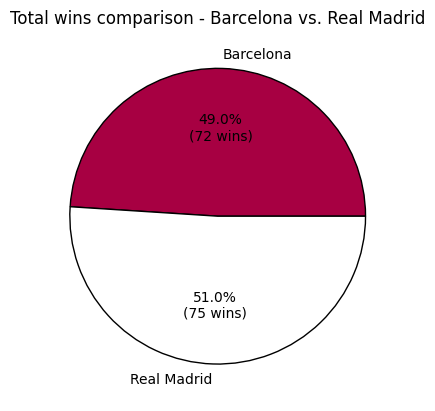

In [18]:
clasico = df_matches[((df_matches['home_team']=='Barcelona')| (df_matches['home_team']=='Real Madrid')) & ((df_matches['away_team']=='Barcelona')| (df_matches['away_team']=='Real Madrid'))]

clasico_wins = clasico.groupby(['home_team','winner']).size()
Barcelona_wins = clasico_wins[('Barcelona',1)] + clasico_wins[('Real Madrid',2)]
RMadrid_wins = clasico_wins[('Barcelona',2)] + clasico_wins[('Real Madrid',1)]

def labelpie(pct, allvals, param):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} {param})"

clasico_wins_data = [Barcelona_wins, RMadrid_wins]
plt.pie(clasico_wins_data, 
        labels=['Barcelona' , 'Real Madrid'], 
        autopct=lambda pct: labelpie(pct, clasico_wins_data, 'wins'), 
        colors=['#A70042', '#FFFFFF'],
        wedgeprops=dict(edgecolor='black', linewidth=1),)
plt.title("Total wins comparison - Barcelona vs. Real Madrid")
plt.show()

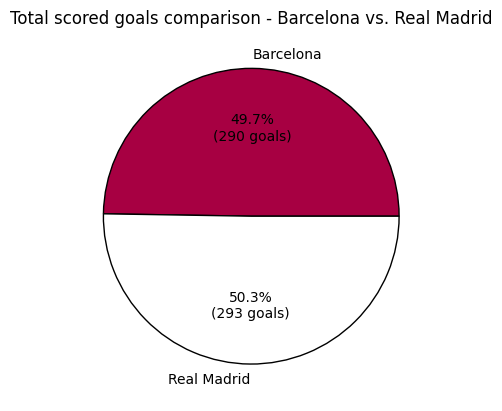

In [19]:
clasico_score = clasico[['home_team' , 'home_score' , 'away_score']]
Barcelona_score = clasico_score[clasico_score["home_team"]=="Barcelona"]["home_score"].sum() + clasico_score[clasico_score["home_team"]=="Real Madrid"]["away_score"].sum()
RMadrid_score = clasico_score[clasico_score["home_team"]=="Real Madrid"]["home_score"].sum() + clasico_score[clasico_score["home_team"]=="Barcelona"]["away_score"].sum()

clasico_scores_data = [Barcelona_score, RMadrid_score]
plt.pie(clasico_scores_data, labels=['Barcelona' , 'Real Madrid'], 
        autopct=lambda pct: labelpie(pct, clasico_scores_data, 'goals' ), 
        colors=['#A70042', '#FFFFFF'],
        wedgeprops=dict(edgecolor='black', linewidth=1))
plt.title("Total scored goals comparison - Barcelona vs. Real Madrid")
plt.show()

In [20]:
def plot_direct_confrontations_stats(team1, team2):
    confrontation = df_matches[((df_matches['home_team'] == team1)| (df_matches['home_team']== team2 )) & ((df_matches['away_team']== team1 )| (df_matches['away_team']== team2 ))]

    confrontation_wins = confrontation.groupby(['home_team','winner']).size()
    team1_wins = confrontation_wins.get((team1, 1), 0) + confrontation_wins.get((team2, 2), 0)
    team2_wins = confrontation_wins.get((team1, 2), 0) + confrontation_wins.get((team2, 1), 0)

    fig, ax = plt.subplots(1,2)
    confrontation_wins_data = [team1_wins, team2_wins]
    ax[0].pie(confrontation_wins_data, labels=[ team1  ,  team2 ], 
              autopct=lambda pct: labelpie(pct, confrontation_wins_data, 'wins' ),
        wedgeprops=dict(edgecolor='black', linewidth=1))
    ax[0].set_title("Total wins comparison")

    confrontation_score = confrontation[['home_team' , 'home_score' , 'away_score']]
    team1_score = confrontation_score[confrontation_score["home_team"]== team1 ]["home_score"].sum() + confrontation_score[confrontation_score["home_team"]== team2 ]["away_score"].sum()
    team2_score = confrontation_score[confrontation_score["home_team"]== team2 ]["home_score"].sum() + confrontation_score[confrontation_score["home_team"]== team1 ]["away_score"].sum()

    confrontation_scores_data = [team1_score, team2_score]
    ax[1].pie(confrontation_scores_data, labels=[ team1  ,  team2 ], 
              autopct=lambda pct: labelpie(pct, confrontation_scores_data, 'goals' ),
        wedgeprops=dict(edgecolor='black', linewidth=1))
    ax[1].set_title("Total scored goals comparison")

    return ax

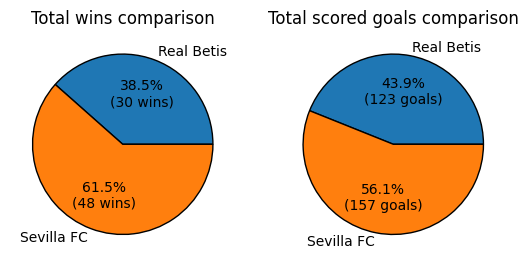

In [21]:
ax = plot_direct_confrontations_stats('Real Betis', 'Sevilla FC')
plt.show()

# Exercise 6
Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the longest undefeated streaks in a horizontal bar plot, indicating in each bar the team name and the dates it held that streak, for instance, Real Sociedad 22/04/1979 - 04/05/1980.

In [22]:
# create a copy of the main dataframe for both the home and the away team
df_streak_home = df_matches[['season', 'date', 'home_team', 'winner']].copy()
df_streak_away = df_matches[['season', 'date', 'away_team', 'winner']].copy()

# create a new column called "result" that shows if the home team wins, draws or losses
df_streak_home['result'] = df_streak_home['winner'].replace({1: 'win', 'X': 'draw', 2: 'loss'})
df_streak_home = df_streak_home.drop(columns='winner').rename(columns={'home_team':'team'})

# create a new column called "result" that shows if the home team wins, draws or losses (1 is a loss here)
df_streak_away['result'] = df_streak_away['winner'].replace({1: 'loss', 'X': 'draw', 2: 'win'})
df_streak_away = df_streak_away.drop(columns='winner').rename(columns={'away_team':'team'})

# combine the two dataframes together, and drop the games that are not played yet
df_streaks = pd.merge(df_streak_home, df_streak_away, how='outer').dropna()

# create a new column that has the value True if the result value is 'win' or 'draw' otherwise it is false
df_streaks['streak_continues'] = df_streaks['result'].isin(['win', 'draw'])

# create a new column that holds the id of seperate streaks. The streaks are reset when a False is met
df_streaks['streak_id'] = (~df_streaks['streak_continues']).groupby(df_streaks['team']).cumsum()

# df_streaks[(df_streaks['team'] == 'Real Sociedad')]# & (df_streaks['streak_id'] == 442)]
# grouping by the team and the streak_id, calculate the start date and end date of all the streaks, and their lenght
df_streaks = df_streaks.groupby(['team', 'streak_id'], as_index=False).agg(
    start_date=('date', 'first'),
    end_date=('date', 'last'),
    streak_length=('date', 'size')
)

# substract 1 from the length of the streak (It should not take the startdate into account)
df_streaks['streak_length'] = df_streaks['streak_length'] - 1
# remove streaks that have a length of 0
df_streaks = df_streaks[df_streaks['streak_length'] > 0]

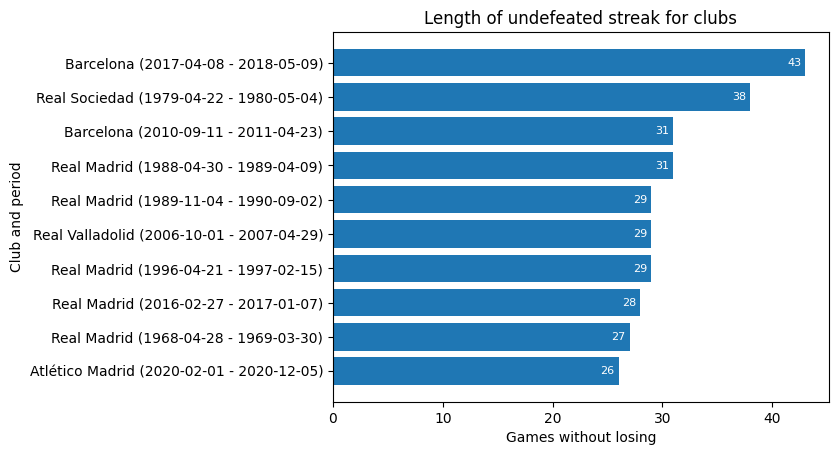

In [23]:
# sort the values by streak_length and only save the top 10
top_10_streaks = df_streaks.sort_values(by='streak_length', ascending=False).head(10)
# create a column for the bar name
top_10_streaks['bar_name'] = top_10_streaks['team'] + ' (' + top_10_streaks['start_date'].astype(str) + ' - ' + top_10_streaks['end_date'].astype(str) + ')'

# plot the top 10 longest streaks
plt.barh(top_10_streaks['bar_name'][::-1], top_10_streaks['streak_length'][::-1])
plt.xlabel('Games without losing')
plt.ylabel('Club and period')
plt.title('Length of undefeated streak for clubs')
for i, value in enumerate(top_10_streaks['streak_length'][::-1]):
    plt.text(value-1, i, str(int(value)), va='center', ha='center', fontsize=8, color='white')
plt.show()

# Exercise 7
Create a table with the final standings of each season (and division), that is, a table that contains all the teams ordered (in descending order) by the number of points they got during that season, and some other aggregate statistics. The table must contain the following columns: season, division, ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that standings of one season come before standings of previous one, and standings of 1st division come before standings of 2nd division.<br><br>
Save the final table in Excel with the name _SeasonStandings.xlsx_ in the _reports/_ folder.

In [24]:
%%time

df_filtered = df_matches[df_matches['season']!='2021-2022'].dropna(subset=['home_score', 'away_score', 'winner'])
df_filtered['home_score'] = df_filtered['home_score'].astype(int)
df_filtered['away_score'] = df_filtered['away_score'].astype(int)

home_grouped = df_filtered.groupby(['season', 'division', 'home_team']).agg(
    GF=('home_score', 'sum'),
    GA=('away_score', 'sum'),
    W=('winner', lambda x: (x == 1).sum()),
    L=('winner', lambda x: (x == 2).sum()),
    T=('winner', lambda x: (x == 'X').sum())
).reset_index()

away_grouped = df_filtered.groupby(['season', 'division', 'away_team']).agg(
    GF=('away_score', 'sum'),
    GA=('home_score', 'sum'),
    W=('winner', lambda x: (x == 2).sum()),
    L=('winner', lambda x: (x == 1).sum()),
    T=('winner', lambda x: (x == 'X').sum())
).reset_index()

home_grouped.rename(columns={'home_team': 'team'}, inplace=True)
away_grouped.rename(columns={'away_team': 'team'}, inplace=True)

combined = pd.concat([home_grouped, away_grouped]).fillna(0)

combined['GD'] = combined['GF'] - combined['GA']

combined['season_year'] = combined['season'].str.split('-').str[0].astype(int)
combined['Pts'] = np.where(
    combined['season_year'] < 1995,
    combined['W'] * 2 + combined['T'],
    combined['W'] * 3 + combined['T']
)

final_result = combined.groupby(['season', 'division', 'team']).agg(
    GF=('GF', 'sum'),
    GA=('GA', 'sum'),
    GD=('GD', 'sum'),
    W=('W', 'sum'),
    L=('L', 'sum'),
    T=('T', 'sum'),
    Pts=('Pts', 'sum')
).reset_index()

final_result = final_result.sort_values(by=['season', 'division', 'Pts', 'GD', 'GF'], ascending=[True, True, False, False, False])
final_result['rank'] = final_result.groupby(['season', 'division']).cumcount() + 1

final_result = final_result[['season', 'division', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']]
final_result = final_result.sort_values(by=['season','division','rank'],ascending=[False,True,True]).reset_index(drop=True)

# Display the sorted DataFrame
final_result = final_result[['season', 'division','rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']]
final_result.to_excel('../reports/SeasonStandings.xlsx',index=False)
final_result

CPU times: user 1.67 s, sys: 10.3 ms, total: 1.68 s
Wall time: 1.71 s


,season,division,rank,team,GF,GA,GD,W,L,T,Pts
0,2020-2021,1,1,Atlético Madrid,67,25,42,26,4,8,86
1,2020-2021,1,2,Real Madrid,67,28,39,25,4,9,84
2,2020-2021,1,3,Barcelona,85,38,47,24,7,7,79
3,2020-2021,1,4,Sevilla FC,53,33,20,24,9,5,77
4,2020-2021,1,5,Real Sociedad,59,38,21,17,10,11,62
...,...,...,...,...,...,...,...,...,...,...,...
2739,1928-1929,1,6,Athletic Madrid,43,41,2,8,8,2,18
2740,1928-1929,1,7,Espanyol,32,38,-6,7,7,4,18
2741,1928-1929,1,8,Catalunya,45,49,-4,6,8,4,16
2742,1928-1929,1,9,Real Unión,40,42,-2,5,11,2,12


# Exercise 8
Villarreal is a team that has grown a lot in recent decades. Specially ever since some billionaire guy bought it (Fernando Roig, from Mercadona). Make a line plot showing the rank of Villarreal at the end of each season, from the oldest ones (left) to the earliest ones (right). Consider rankings in 2nd division to be a continuation of the 1st one, that is, if there’s N teams in 1st division and Villarreal got r position in 2nd division, then it should be placed in N + r. Draw in the same plot a line showing the cut between 1st and 2nd division.<br><br>
Write a function that, given n team names, plots the graph described above of each one of them superposed. Function prototype should be like _plot_ranking_evolution(team1, team2, ..., teamN)_ and return the plot object (note that function should not take one array-type argument, but n arguments). Use it to compare the evolution of all the teams that currently play in 1st division.

In [25]:
def calc_continuous_rank(team_count_dict, row):
        if row['division'] == 2:
            return team_count_dict[(row['season'], 1)] + row['rank']
        else:
            return row['rank']
            
def plot_ranking_evolution(*args):
    team_count_dict = dict(final_result.groupby(['season', 'division'])['division'].agg(['count'])['count'])
    final_result['continuous_rank'] = final_result.apply(lambda row: calc_continuous_rank(team_count_dict, row), axis=1)
    fig, ax = plt.subplots(figsize=(15,6))
    seasons = final_result['season'].unique()
    division_cut = [team_count_dict.get((season, 1), None) for season in seasons] 
    ax.plot(seasons, division_cut, label='division cut', linestyle='dashed', linewidth=3)#, color="#FF0000")
    
    for team in args:
        ax.plot(list(final_result[final_result['team'] == team]['season']), list(final_result[final_result['team'] == team]['continuous_rank']), label=team)
    
    ax.set_xticks(range(0, len(list(final_result['season'].unique()))))
    ax.set_xticklabels(list(final_result['season'].unique()), rotation=90)
    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid()
    plt.xlabel('Season')
    plt.ylabel('Ranking')
    plt.title('Ranking evolution of teams')
    return ax

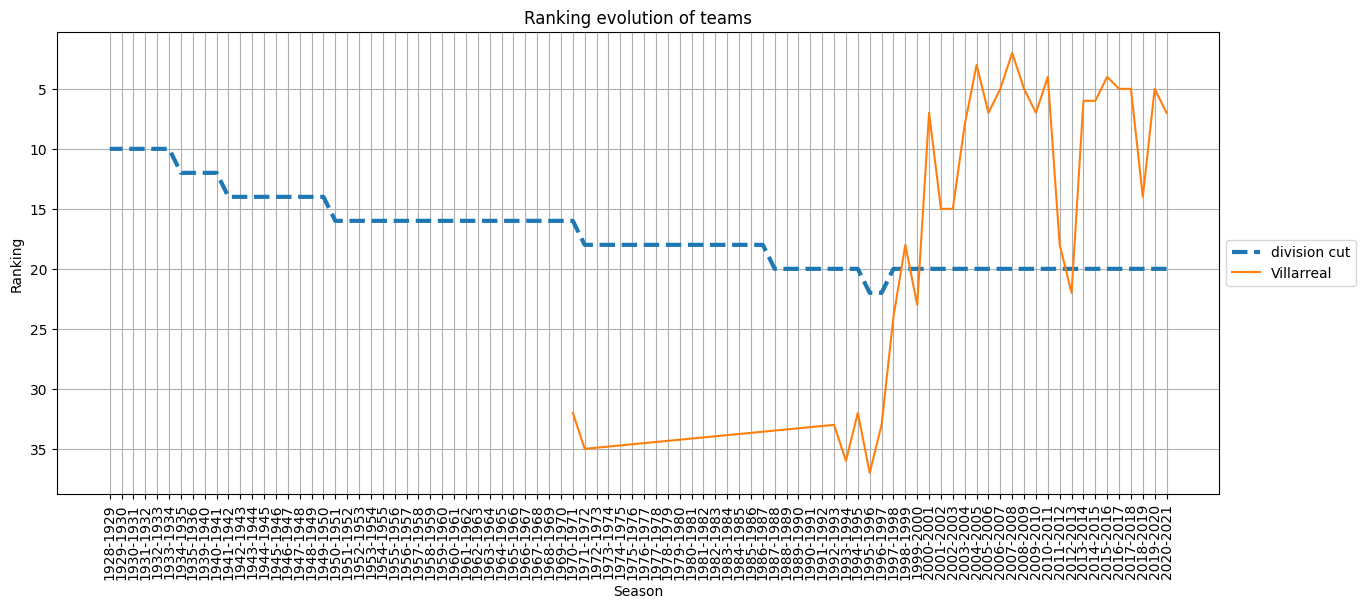

In [26]:
final_result_plot = plot_ranking_evolution('Villarreal')

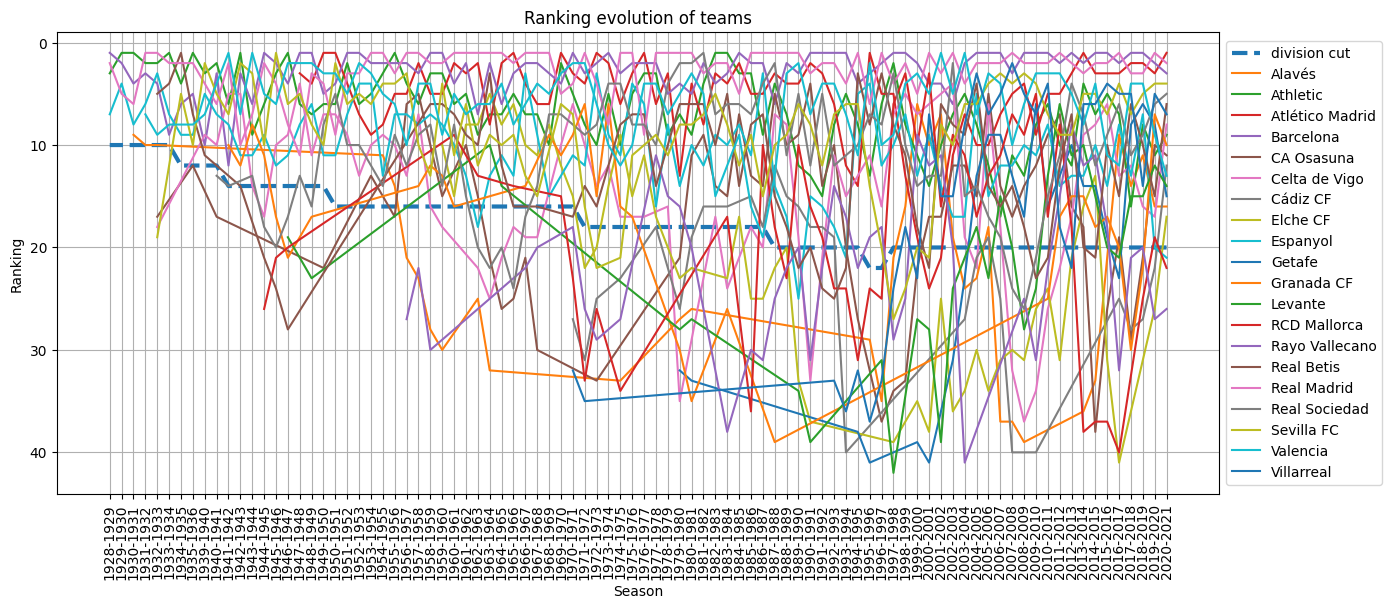

In [27]:
final_result_plot = plot_ranking_evolution(*sorted(df_matches[(df_matches['season'] == '2021-2022') & (df_matches['division'] == 1)]['home_team'].unique()))

# Exercise 9
In football jargon, those teams that are permanently descending and ascending between 1st and 2nd division are called elevator teams. What are the most elevator teams in LaLiga? Plot the history of the top 5 of them using the function from exercise 9.

In [28]:
def last_season(seasons, season):
    if season in seasons:
        ind = seasons.index(season)
        if ind > 0:
            return seasons[ind - 1]
    return None
    
def elevator_teams(df, current_season):
    previous_season = last_season(df.season.sort_values().unique().tolist(), current_season)
    
    teams = df[(df.season == current_season) & (df.division == 1) &
                              (df['home_team'].isin(
                                  df[(df.season == previous_season) & (df.division == 2)].home_team.unique()
                              ))]
    
    teams = pd.concat([teams,df[(df.season == current_season) & (df.division == 2) &
                              (df['home_team'].isin(
                                  df[(df.season == previous_season) & (df.division == 1)].home_team.unique()
                              ))]])
    
    return [current_season, teams.home_team.unique().tolist()]

elevator = pd.DataFrame([])
for season in df_matches.season.unique():
    elevator = pd.concat([elevator,
                          pd.DataFrame([elevator_teams(df_matches,season)],columns=['season','elevator_teams']).explode('elevator_teams')])

elevator = elevator.dropna().reset_index(drop=True)
elevator_teams = elevator.groupby('elevator_teams').count().sort_values(by='season',ascending=False).reset_index()
print(elevator_teams.head(10))
elevator_teams = list(elevator_teams['elevator_teams'].head())

    elevator_teams  season
0   Dep. La Coruña      18
1           Racing      17
2   Rayo Vallecano      14
3    Celta de Vigo      13
4  Real Valladolid      12
5       Real Betis      11
6     RCD Mallorca      10
7       CA Osasuna       9
8    Real Sociedad       9
9      Real Murcia       9


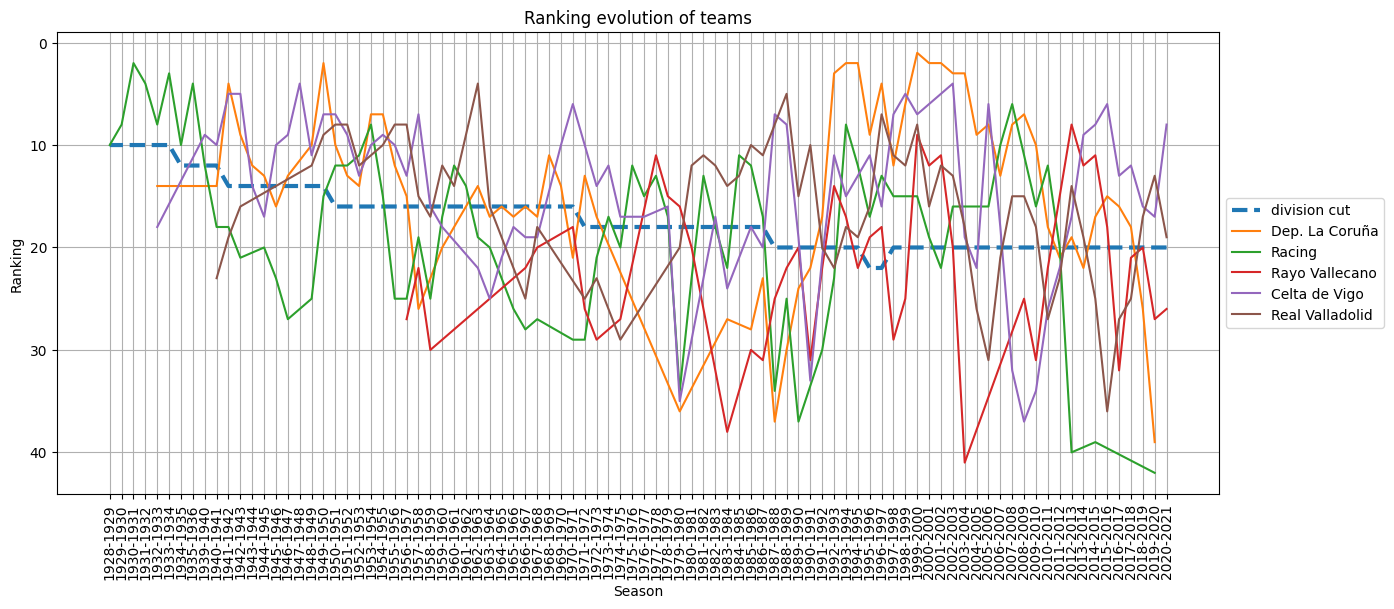

In [29]:
plot = plot_ranking_evolution(*elevator_teams)

# Exercise 10
Create a table that is the same as the one in exercise 7, but not only with the season final standings, but the standings at the end of each matchday. Columns are the same, including matchday that tells about which matchday from the season these standings are from. Would you be able to add a new column last_5 with the result of last 5 matches? This column should contain a list like _["W", "L", "W", "T", "T"]_. In this list, the first item is the immediate previous match, the second one is the match before this one, and so on. If there are no 5 previous matches (because matchday < 6, for instance) then just make the list shorter.
<br>
Save the final table in Excel with the name _MatchdayStandings.xlsx_ in the _reports/_ folder.

In [30]:
%%time

df = df_matches.copy()[['season','division','matchday','home_team','away_team','home_score','away_score','winner']].dropna()
df['home_score'] = df['home_score'].astype(int)
df['away_score'] = df['away_score'].astype(int)
df

def get_last_results(row):
    season = row['season']
    division = row['division']
    matchday = row['matchday']
    team = row['team']
    
    filtered = final_result[
        (final_result['season'] == season) &
        (final_result['division'] == division) &
        (final_result['matchday'] <= matchday) &
        (final_result['matchday'] >= max(1, matchday - 4)) &
        (final_result['team'] == team)
    ]
    return filtered['result'].tolist()[-5:][::-1]


df_filtered = df.dropna(subset=['home_score', 'away_score', 'winner'])


home_grouped = df_filtered.groupby(['season', 'division', 'matchday', 'home_team']).agg(
    GF=('home_score', 'sum'),
    GA=('away_score', 'sum'),
    W=('winner', lambda x: (x == 1).sum()),
    L=('winner', lambda x: (x == 2).sum()),
    T=('winner', lambda x: (x == 'X').sum())
).reset_index()


away_grouped = df_filtered.groupby(['season', 'division', 'matchday', 'away_team']).agg(
    GF=('away_score', 'sum'),
    GA=('home_score', 'sum'),
    W=('winner', lambda x: (x == 2).sum()),
    L=('winner', lambda x: (x == 1).sum()),
    T=('winner', lambda x: (x == 'X').sum())
).reset_index()


away_grouped.rename(columns={'away_team': 'team'}, inplace=True)


combined = pd.concat([home_grouped.rename(columns={'home_team': 'team', 'result': 'home_result'}),
                      away_grouped.rename(columns={'away_team': 'team', 'result': 'away_result'})]).fillna(0)


combined['result'] = combined.apply(
    lambda row: 'W' if row['W'] > 0 else ('L' if row['L'] > 0 else 'T'), axis=1
)


combined['GD'] = combined['GF'] - combined['GA']

combined['season_year'] = combined['season'].str.split('-').str[0].astype(int)
combined['Pts'] = np.where(
    combined['season_year'] < 1995,
    combined['W'] * 2 + combined['T'],
    combined['W'] * 3 + combined['T']
)


final_result = combined.groupby(['season', 'division', 'matchday', 'team']).agg(
    GF=('GF', 'sum'),
    GA=('GA', 'sum'),
    GD=('GD', 'sum'),
    W=('W', 'sum'),
    L=('L', 'sum'),
    T=('T', 'sum'),
    Pts=('Pts', 'sum'),
    result = ('result', 'first')
).reset_index()


final_result = final_result.sort_values(by=['season', 'division', 'matchday', 'team'])
final_result[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']] = final_result.groupby(['season', 'division', 'team'])[
    ['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']
].cumsum()


final_result = final_result.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'], ascending=[True, True, True, False, False, False])
final_result['rank'] = final_result.groupby(['season', 'division', 'matchday']).cumcount() + 1
final_result = final_result.sort_values(by=['season', 'division', 'matchday', 'rank'], ascending=[False, True, True, True]).reset_index(drop=True)


final_result = final_result[['season', 'division', 'matchday', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'result']]

final_result['last_5'] = final_result.apply(get_last_results, axis=1)

final_result.to_excel('../reports/MatchdayStandings.xlsx',index=False)

final_result

CPU times: user 23min 23s, sys: 409 ms, total: 23min 24s
Wall time: 23min 24s


,season,division,matchday,rank,team,GF,GA,GD,W,L,T,Pts,result,last_5
0,2021-2022,1,1,1,Real Madrid,4,1,3,1,0,0,3,W,[W]
1,2021-2022,1,1,2,Sevilla FC,3,0,3,1,0,0,3,W,[W]
2,2021-2022,1,1,3,Barcelona,4,2,2,1,0,0,3,W,[W]
3,2021-2022,1,1,4,Atlético Madrid,2,1,1,1,0,0,3,W,[W]
4,2021-2022,1,1,5,Valencia,1,0,1,1,0,0,3,W,[W]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95989,1928-1929,1,18,6,Athletic Madrid,43,41,2,8,8,2,18,W,"[W, T, W, W, L]"
95990,1928-1929,1,18,7,Espanyol,32,38,-6,7,7,4,18,L,"[L, T, L, L, T]"
95991,1928-1929,1,18,8,Catalunya,45,49,-4,6,8,4,16,L,"[L, W, L, T, T]"
95992,1928-1929,1,18,9,Real Unión,40,42,-2,5,11,2,12,L,"[L, L, L, L, W]"
